In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random

import backwardcompatibilityml.loss as bcloss
import backwardcompatibilityml.scores as scores

# Initialize random seed
random.seed(123)
torch.manual_seed(456)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

%matplotlib inline

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

torch.backends.cudnn.enabled = False

In [3]:
train_loader = list(torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('datasets/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True))

test_loader = list(torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('datasets/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True))

In [4]:
train_loader_a = train_loader[:int(len(train_loader)/2)]
train_loader_b = train_loader[int(len(train_loader)/2):]

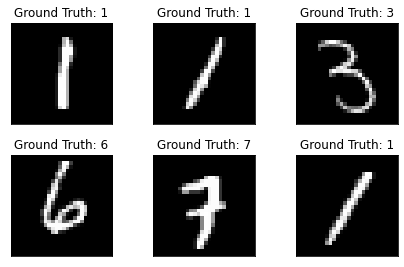

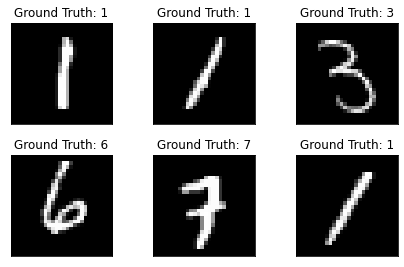

In [5]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(train_loader_a[0][0][i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(train_loader_a[0][1][i]))
    plt.xticks([])
    plt.yticks([])
fig

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x, F.softmax(x, dim=1), F.log_softmax(x, dim=1)

In [7]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [8]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader_a)*batch_size_train for i in range(n_epochs + 1)]

In [9]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader_a):
        optimizer.zero_grad()
        _, _, output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader_a)*batch_size_train,
                100. * batch_idx / len(train_loader_a), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader_a)*batch_size_train))

In [10]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            _, _, output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(train_loader_a)*batch_size_train
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(train_loader_a)*batch_size_train,
            100. * correct / (len(train_loader_a)*batch_size_train)))

In [11]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/home/xavier/mnt/datapartition/work/virtualenvs/venv/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7645, Accuracy: 1359/30016 (5%)

Train Epoch: 1 [0/30016 (0%)]	Loss: 2.338004
Train Epoch: 1 [640/30016 (2%)]	Loss: 2.281939
Train Epoch: 1 [1280/30016 (4%)]	Loss: 2.274189
Train Epoch: 1 [1920/30016 (6%)]	Loss: 2.249804
Train Epoch: 1 [2560/30016 (9%)]	Loss: 2.218965
Train Epoch: 1 [3200/30016 (11%)]	Loss: 2.199637
Train Epoch: 1 [3840/30016 (13%)]	Loss: 2.167684
Train Epoch: 1 [4480/30016 (15%)]	Loss: 2.119798
Train Epoch: 1 [5120/30016 (17%)]	Loss: 2.025222
Train Epoch: 1 [5760/30016 (19%)]	Loss: 1.932501
Train Epoch: 1 [6400/30016 (21%)]	Loss: 1.671945
Train Epoch: 1 [7040/30016 (23%)]	Loss: 1.561831
Train Epoch: 1 [7680/30016 (26%)]	Loss: 1.626387
Train Epoch: 1 [8320/30016 (28%)]	Loss: 1.685211
Train Epoch: 1 [8960/30016 (30%)]	Loss: 1.400331
Train Epoch: 1 [9600/30016 (32%)]	Loss: 1.427622
Train Epoch: 1 [10240/30016 (34%)]	Loss: 0.989379
Train Epoch: 1 [10880/30016 (36%)]	Loss: 1.192472
Train Epoch: 1 [11520/30016 (38%)]	Loss: 1.240278
Train Epoch: 1 [12

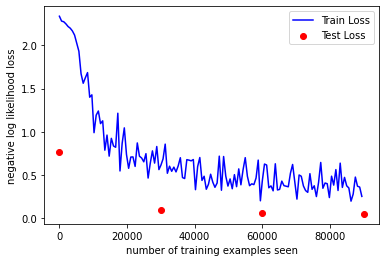

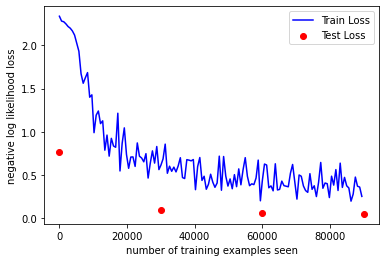

In [12]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [13]:
with torch.no_grad():
    _, _, output = network(test_loader[0][0])

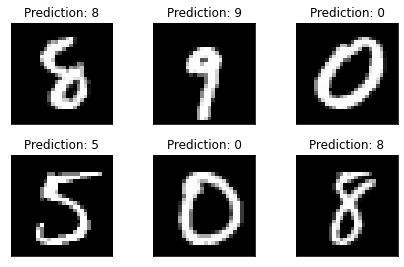

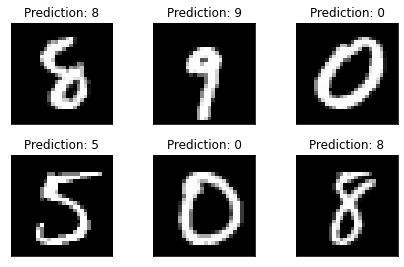

In [14]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(test_loader[0][0][i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
        output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
fig

In [15]:
import copy
import importlib
importlib.reload(bcloss)

h1 = copy.deepcopy(network)
h2 = copy.deepcopy(network)
h1.eval()
new_optimizer = optim.SGD(h2.parameters(), lr=learning_rate, momentum=momentum)
lambda_c = 1.0
si_loss = bcloss.StrictImitationNLLLoss(h1, h2, lambda_c)

In [16]:
update_train_losses = []
update_train_counter = []
update_test_losses = []
update_test_counter = [i*len(train_loader_b)*batch_size_train for i in range(n_epochs + 1)]

In [17]:
def train_update(epoch):
    for batch_idx, (data, target) in enumerate(train_loader_b):
        new_optimizer.zero_grad()
        loss = si_loss(data, target)
        loss.backward()
        new_optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader_b)*batch_size_train,
                100. * batch_idx / len(train_loader_b), loss.item()))
            update_train_losses.append(loss.item())
            update_train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader_b)*batch_size_train))

In [18]:
def test_update():
    h2.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            _, _, output = h2(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(train_loader_b)*batch_size_train
    update_test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(train_loader_b)*batch_size_train,
    100. * correct / (len(train_loader_b)*batch_size_train)))

In [19]:
test_update()
for epoch in range(1, n_epochs + 1):
    train_update(epoch)
    test_update()


Test set: Avg. loss: 0.0484, Accuracy: 9571/30016 (32%)

Train Epoch: 1 [0/30016 (0%)]	Loss: 7.641572
Train Epoch: 1 [640/30016 (2%)]	Loss: 140.985657
Train Epoch: 1 [1280/30016 (4%)]	Loss: 141.172012
Train Epoch: 1 [1920/30016 (6%)]	Loss: 131.384872
Train Epoch: 1 [2560/30016 (9%)]	Loss: 141.483444
Train Epoch: 1 [3200/30016 (11%)]	Loss: 144.578812
Train Epoch: 1 [3840/30016 (13%)]	Loss: 148.795059
Train Epoch: 1 [4480/30016 (15%)]	Loss: 141.666748
Train Epoch: 1 [5120/30016 (17%)]	Loss: 147.860840
Train Epoch: 1 [5760/30016 (19%)]	Loss: 145.550690
Train Epoch: 1 [6400/30016 (21%)]	Loss: 142.376770
Train Epoch: 1 [7040/30016 (23%)]	Loss: 145.911255
Train Epoch: 1 [7680/30016 (26%)]	Loss: 137.615143
Train Epoch: 1 [8320/30016 (28%)]	Loss: 136.887802
Train Epoch: 1 [8960/30016 (30%)]	Loss: 141.392456
Train Epoch: 1 [9600/30016 (32%)]	Loss: 145.154831
Train Epoch: 1 [10240/30016 (34%)]	Loss: 139.295868
Train Epoch: 1 [10880/30016 (36%)]	Loss: 138.034180
Train Epoch: 1 [11520/30016 (38%)

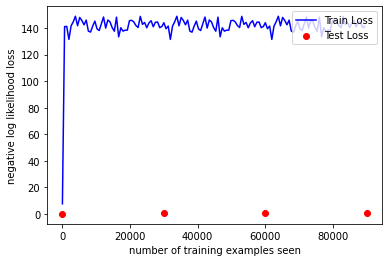

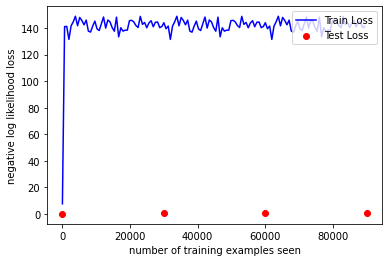

In [20]:
fig = plt.figure()
plt.plot(update_train_counter, update_train_losses, color='blue')
plt.scatter(update_test_counter, update_test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [21]:
h2.eval()
h1.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [22]:
test_index = 2

In [23]:
with torch.no_grad():
    _, _, h1_output = h1(test_loader[test_index][0])
    _, _, h2_output = h2(test_loader[test_index][0])

In [24]:
h1_labels = h1_output.data.max(1)[1]
h2_labels = h2_output.data.max(1)[1]
expected_labels = test_loader[test_index][1]

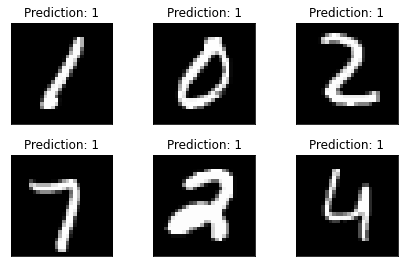

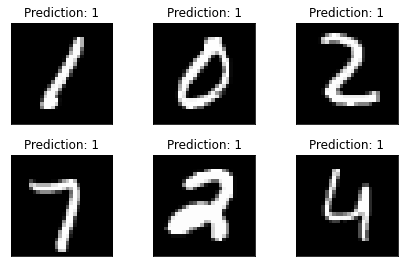

In [25]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(test_loader[test_index][0][i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
        h2_labels[i].item()))
    plt.xticks([])
    plt.yticks([])
fig

In [26]:
trust_compatibility = scores.trust_compatibility_score(h1_labels, h2_labels, expected_labels)
error_compatibility = scores.error_compatibility_score(h1_labels, h2_labels, expected_labels)

print(f"Error Compatibility Score: {error_compatibility}")
print(f"Trust Compatibility Score: {trust_compatibility}")

Error Compatibility Score: 0.925
Trust Compatibility Score: 0.09895833333333333
